In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import scipy
import sys
sys.path.append('../Utility/')
from plot_utility import plot_tme
import control as ct
from discrete_linear_kalman import __kalman_forward_filter__


# Constants

In [2]:
# System Parameters
m = 0.5 # mass
l = 0.2 # distance from rotor to COM
I = 2/5*m*l**2 # Moment of inertia (Iyy) -- assuming drone is a sphere (it is not)
g = 9.81 # gravity constant

# Control Parameters
tau_k_theta = 10 # torque control to stabilize theta
tau_k_thetadot = 20 # torque control to provide thetadot damping
tau_k_x = 0.01 # torque control to control x position
tau_k_xdot = 0.2 # torque control to provide xdot damping
F_k_z = 1000 # Force control to control z position
F_k_zdot = 10000 # Force control to control z position

F0 = m*g

# Noise for measurements: (standard deviations)
# v = [0.01, 0.001, 0.2, 0.2]

# Desired trajectory

In [3]:
def desired_trajectory(t):
    theta_des = 0*np.ones_like(t)
    z_des = 1*np.ones_like(t)
    x_des = np.sin(0.05*t)
    return theta_des, x_des, z_des

# Nonlinear continuous time dynamics with control

In [4]:
def control(X, t):
    theta, thetadot, x, xdot, z, zdot = np.ravel(X)
    
    # desired trajectory
    theta_des, x_des, z_des = desired_trajectory(t)
    
    # error
    x_err = x_des - x
    z_err = z_des - z
    
    # control
    tau = -(tau_k_x*x_err - tau_k_xdot*xdot)  + (tau_k_theta*(-theta) - tau_k_thetadot*thetadot)
    F = (F_k_z*z_err - F_k_zdot*zdot)
    
    return F, tau

In [5]:
def f(X, t):
    theta, thetadot, x, xdot, z, zdot = X
    
    # control
    F, tau = control(X, t)
    
    # dynamics
    d_theta = thetadot
    d_thetadot = tau/I
    d_x = xdot
    d_xdot = -F*np.sin(theta)/m
    d_z = zdot
    d_zdot = (F*np.cos(theta)-m*g)/m
    
    d_x = [d_theta, d_thetadot, d_x, d_xdot, d_z, d_zdot]
    
    return d_x

# Run simulation

In [6]:
t = np.arange(0, 1000, 0.1)

x0 = [(np.random.random()-0.5)*1e-3 for i in range(6)]

result = odeint(f, x0, t)
X = result.T

# Plot results

In [7]:
theta = X[0, :]
x = X[2, :]
z = X[4, :]

theta_des, x_des, z_des = desired_trajectory(t)

<Axes: xlabel='Time', ylabel='z'>

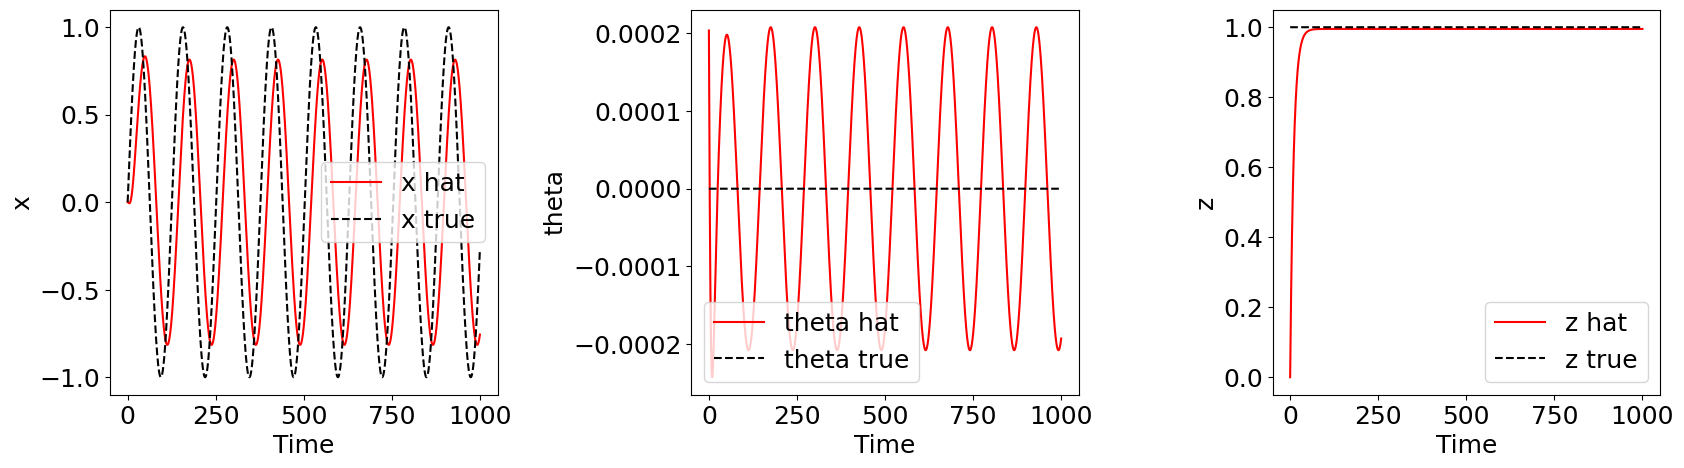

In [8]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t, x_des, None, x, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(t, theta_des, None, theta, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(t, z_des, None, z, label_var='z', ax=ax3)

# Measurements

In [9]:
def h(x, v):
    theta, thetadot, x, xdot, z, zdot = x
    
    y = np.array([theta, thetadot, x, z])
    noise = np.array( [np.random.normal(0, vi) for vi in v] )
    
    return (y + noise).tolist()

<Axes: xlabel='Time', ylabel='z'>

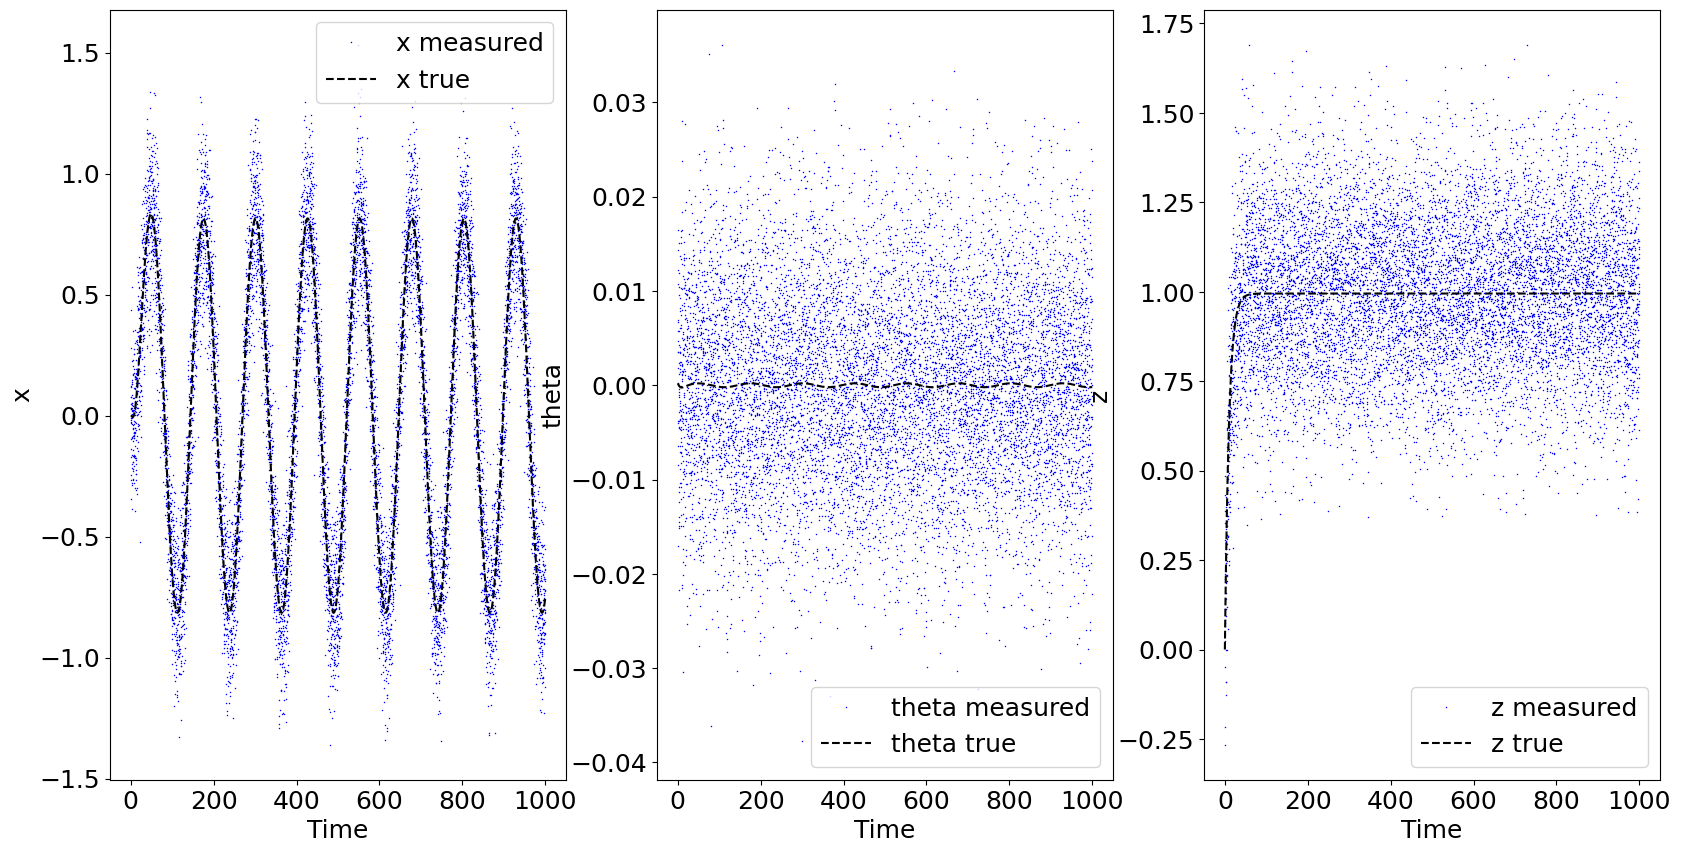

In [10]:
v = [0.01, 0.001, 0.2, 0.2]
Y = np.vstack( [h(X[:,i], v) for i in range(X.shape[1]) ] ).T

figrows = 1
figcols = 3
fig, axs = plt.subplots(figrows, figcols, figsize=(20, 10))
axes = (ax for ax in axs.flatten())


ax = next(axes)
plot_tme(t, x, Y[2,:], None, label_var='x', ax=ax)

ax = next(axes)
plot_tme(t, theta, Y[0,:], None, label_var='theta', ax=ax)

ax = next(axes)
plot_tme(t, z, Y[3,:], None, label_var='z', ax=ax)

# my stuff starts here

# Discrete Linearized

In [11]:

def modified_linear_control(control_function):
    '''decorator to transform the control function to include nonlinearities inside input'''
    def wrapper(X, t):
        F, tau = control_function(X, t)
        theta, thetadot, x, xdot, z, zdot, beta1, beta2, beta3 = np.ravel(X)
        u_B = np.array([0, F*np.sin(theta), 0, F*np.cos(theta), 0, tau, 0, 0, 0])
        return u_B
    return wrapper


@modified_linear_control
def control_linear(X, t):
    theta, thetadot, x, xdot, z, zdot, beta1, beta2, beta3 = np.ravel(X)
    
    # desired trajectory
    theta_des, x_des, z_des = desired_trajectory(t)
    
    # error
    x_err = x_des - x
    z_err = z_des - z
    
    # control
    tau = -(tau_k_x*x_err - tau_k_xdot*xdot)  + (tau_k_theta*(-theta) - tau_k_thetadot*thetadot)
    F = (F_k_z*z_err - F_k_zdot*zdot) - F0
    
    return F, tau


In [12]:
dt = np.mean(np.diff(t))

A_cnt = np.array([[0, 1, 0, 0, 0, 0, 0, 0, 0], 
                  [0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0]])

beta1, beta2, beta3 = 1/I, -1/m, 1/m
Bnot_cnt = np.array([0, beta1, 0, beta2, 0, beta3, 0, 0, 0])

# A_cnt = A_cnt[:-3, :-3]
# Bnot_cnt = Bnot_cnt[:-3] 
A = scipy.linalg.expm(A_cnt*dt)


# to avoid singularities, we integrate the matrix exponential
f_b = lambda s,i: np.matmul(scipy.linalg.expm(A_cnt*s), Bnot_cnt)[i]
B = np.array([scipy.integrate.quad(f_b, 0, dt, args=(i,))[0] for i in range(Bnot_cnt.shape[0])])
A, B

(array([[1. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 1. , 0.1, 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 1. , 0.1, 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ]]),
 array([ 6.25e-01,  1.25e+01, -1.00e-02, -2.00e-01,  1.00e-02,  2.00e-01,
         0.00e+00,  0.00e+00,  0.00e+00]))

# case 1: how well the estimator works with C as identity matrix and states having ideal parameter values

In [13]:
parameter_states = np.ones((3, X.shape[1])) * np.array([beta1, beta2, beta3]).reshape(-1, 1)
X = np.vstack([X, parameter_states])

C: [[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]


<Axes: xlabel='Time', ylabel='beta3'>

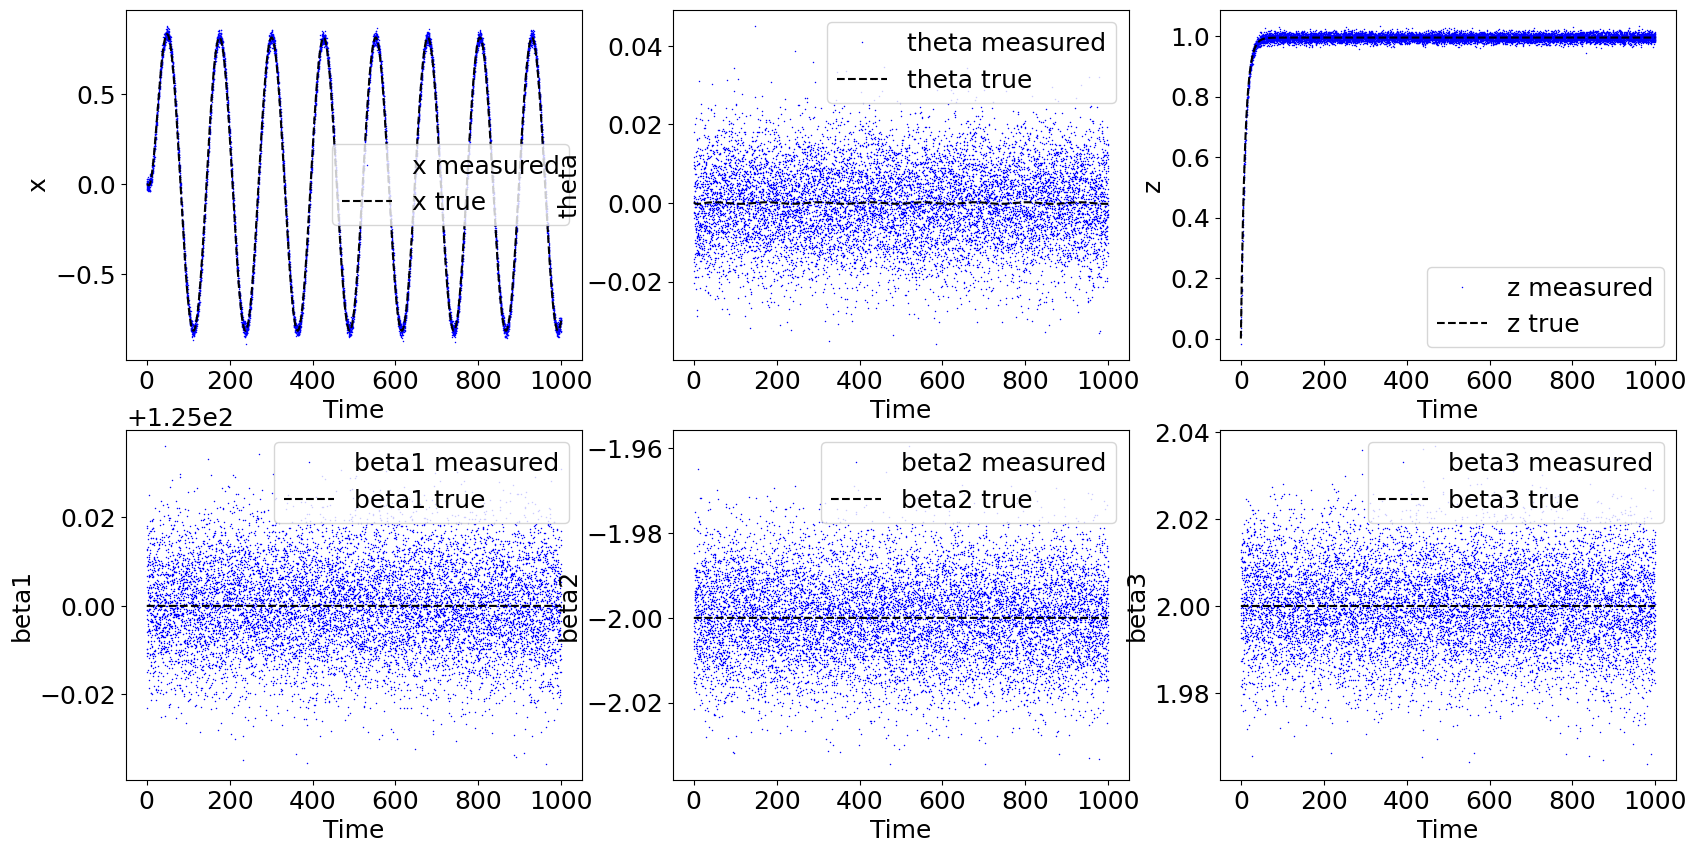

In [18]:
C = np.eye(B.shape[0]) # case 1: we measure all states

# # case 2: few states
# C = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
#                 [0, 0, 1, 0, 1, 0, 0, 0, 0],
#                 [0, 0, 0, 0, 1, 0, 0, 0, 0], 
#                 [0, 0, 0, 0, 1, 0, 1, 2, 3], 
#                 [0, 0, 0, 0, 0, 0, 0, 0, 0], 
#                 [0, 0, 0, 0, 0, 0, 0, 1, 2]]) 


v = [0.01, 0.001, 0.02, 0.02, 0.01, 0.001, 0.01, 0.01, 0.01]

print('C:', C)

def new_h(x, v):
    theta, thetadot, x, xdot, z, zdot, beta1, beta2, beta3 = x
    
    y = np.array([theta, thetadot, x, xdot, z, zdot, beta1, beta2, beta3])
    noise = np.array( [np.random.normal(0, vi) for vi in v] )
    
    return (y + noise).tolist()

Y = np.vstack( [new_h(X[:,i], v) for i in range(X.shape[1]) ] ).T

figrows = 2
figcols = 3
fig, axs = plt.subplots(figrows, figcols, figsize=(20, 10))
axes = (ax for ax in axs.flatten())


ax = next(axes)
plot_tme(t, x, Y[2,:], None, label_var='x', ax=ax)

ax = next(axes)
plot_tme(t, theta, Y[0,:], None, label_var='theta', ax=ax)

ax = next(axes)
plot_tme(t, z, Y[4,:], None, label_var='z', ax=ax)

ax = next(axes)
plot_tme(t, X[-3,:], Y[-3,:], None, label_var='beta1', ax=ax)

ax = next(axes)
plot_tme(t, X[-2,:], Y[-2,:], None, label_var='beta2', ax=ax)

ax = next(axes)
plot_tme(t, X[-1,:], Y[-1,:], None, label_var='beta3', ax=ax)

In [19]:
# is the system observable?
bigO = ct.obsv(A, C)
np.linalg.matrix_rank(bigO) == A.shape[0]

True

### Organize some inputs for the KF

In [20]:
# get the control inputs -- these should be known
# u = control_linear(X, t)
# u = np.vstack(u)
u = np.array([control_linear(X[:,i], t[i]) for i in range(X.shape[1])]).T

# R is determined by the variance, thus the square of the standard deviation
R = np.diag(v)**3

# Q defines how trustworthy the model is. More trusted models result in smoother estimates. 
# But they can be led astray, and are slower to converge 
Q = 1e-4*np.eye(9)

# initial state estimate
x0 = [(np.random.random()-0.5)*20 for i in range(9)]
x0 = np.atleast_2d(x0).T

# initial covariance estimate
P0 = 10*np.eye(9)

# Run the KF

In [21]:
xhat_fp, xhat_fm, P_fp, P_fm = __kalman_forward_filter__(x0, P0, Y, u, A, B, C, R, Q)

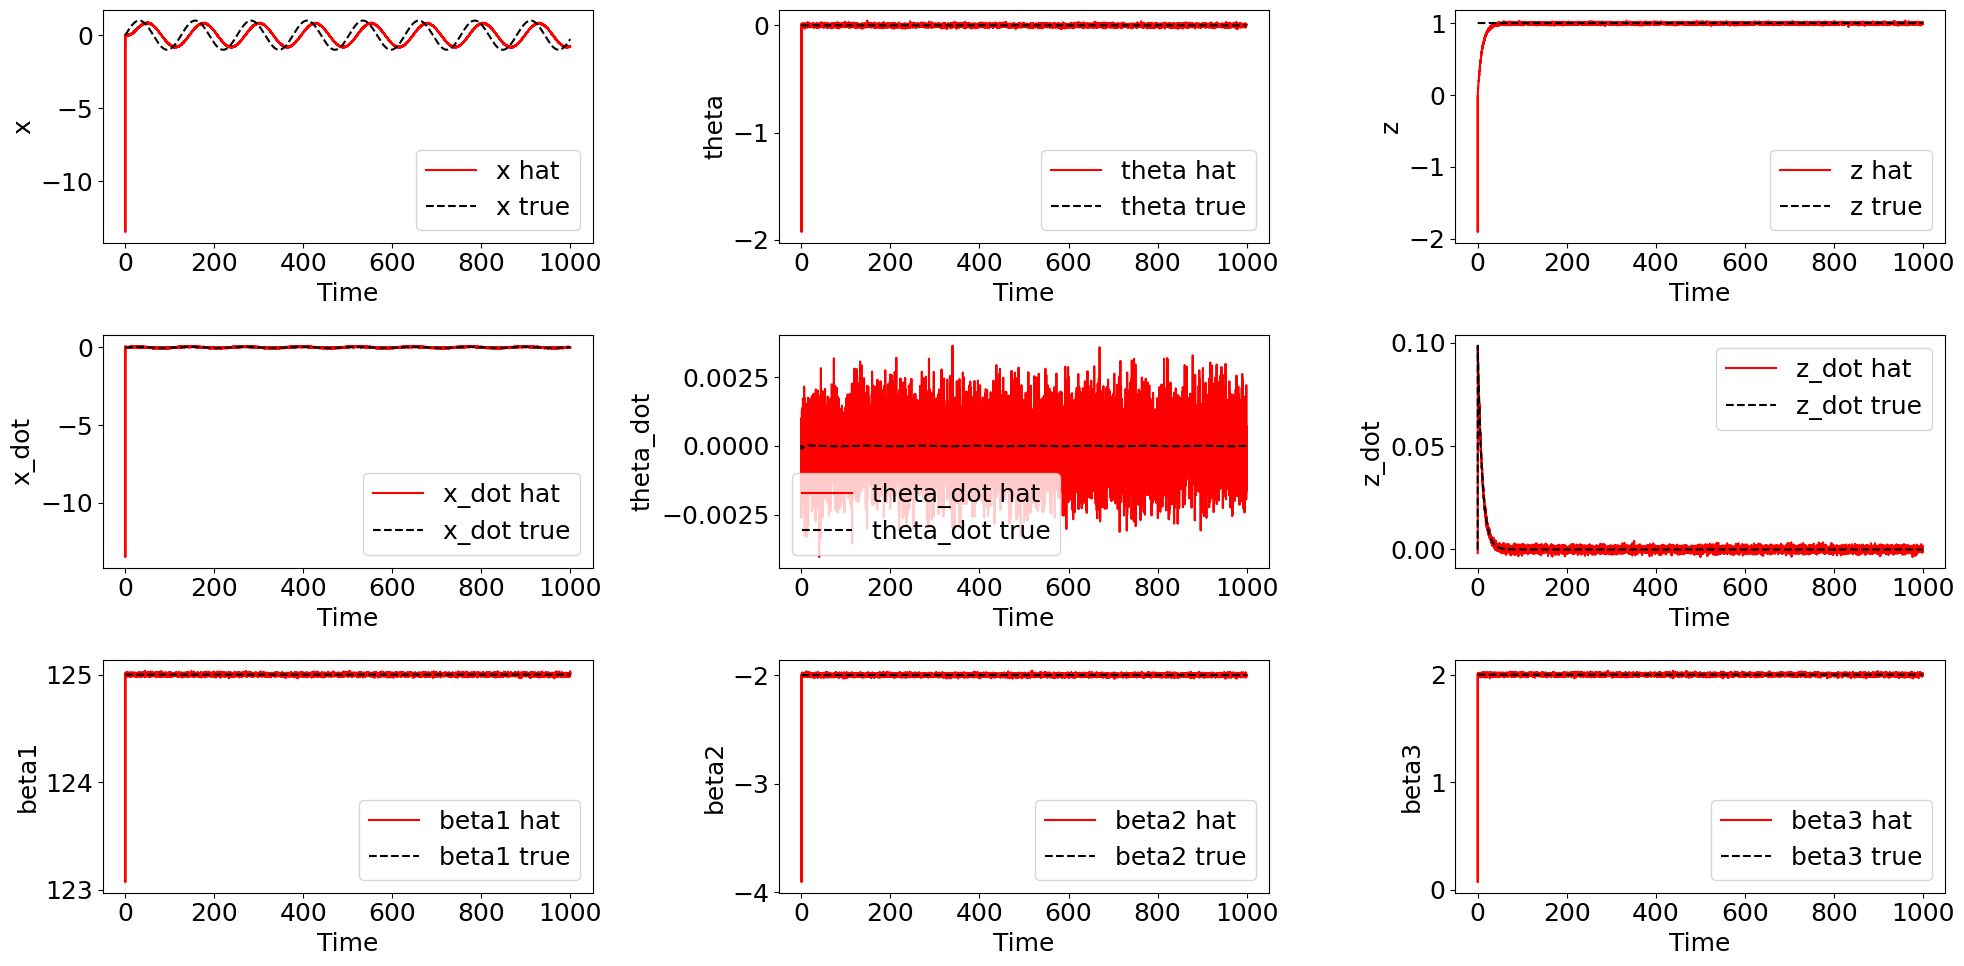

In [22]:
theta_hat = xhat_fp[0, :]
x_hat = xhat_fp[2, :]
z_hat = xhat_fp[4, :]

theta_dot_hat = xhat_fp[1, :]
x_dot_hat = xhat_fp[3, :]
z_dot_hat = xhat_fp[5, :]

theta_dot = X[1, :]
x_dot = X[3, :]
z_dot = X[5, :]

beta1_hat = xhat_fp[6, :]
beta2_hat = xhat_fp[7, :]
beta3_hat = xhat_fp[8, :]

figrow = 3
figcol = 3
fig, axes = plt.subplots(figrow, figcol, figsize=(20,10))
axes = (ax for ax in axes.flatten())

ax = next(axes)
plot_tme(t, x_des, None, x_hat, label_var='x', ax=ax)

ax = next(axes)
plot_tme(t, theta_des, None, theta_hat, label_var='theta', ax=ax)

ax = next(axes)
plot_tme(t, z_des, None, z_hat, label_var='z', ax=ax)

ax = next(axes)
plot_tme(t, x_dot, None, x_dot_hat, label_var='x_dot', ax=ax)

ax = next(axes)
plot_tme(t, theta_dot, None, theta_dot_hat, label_var='theta_dot', ax=ax)

ax = next(axes)
plot_tme(t, z_dot, None, z_dot_hat, label_var='z_dot', ax=ax)

ax = next(axes)
plot_tme(t, np.ones_like(t)*beta1, None, beta1_hat, label_var='beta1', ax=ax)

ax = next(axes)
plot_tme(t, np.ones_like(t)*beta2, None, beta2_hat, label_var='beta2', ax=ax)

ax = next(axes)
plot_tme(t, np.ones_like(t)*beta3, None, beta3_hat, label_var='beta3', ax=ax)

fig.tight_layout()

# Analyze the error

Focus on state x

In [64]:
# Covariance for state x

Px = np.dstack(P_fp)[2,2,:]
Px.shape, len(P_fp)
# P_fp[0]

((10000,), 10000)

Recall that P is the covariance, so its diagonals are the variance. Variance = (Standard Deviation)^2.


In theory, the errors in the estimates should be well approximated by a Normal distribution with zero mean and standard deviation determined by the diagonal element of P. Lets see.

Text(0, 0.5, 'frequency')

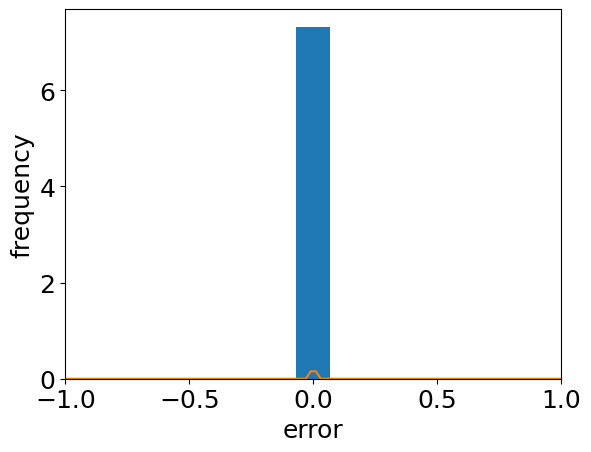

In [65]:
import scipy.stats

xr = np.linspace(-1, 1, 100)
N = scipy.stats.norm(0, np.mean(Px)**0.5 )
pdf = N.pdf(xr)

plt.hist(x_hat-x, bins=100, density=True)
plt.plot(xr, pdf)

plt.xlim(-1,1)

plt.xlabel('error')
plt.ylabel('frequency')

# plt.yscale('log')

Furthermore, 97.7% of the errors should lie under the 3*$\sigma$ bounds. Let's see. 

Text(0, 0.5, 'error')

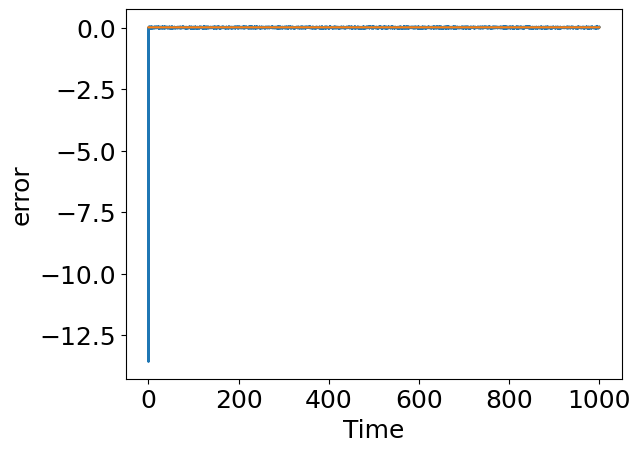

In [66]:
sigma = Px**0.5

plt.plot(t, x_hat-x)
plt.plot(t, 3*sigma)

plt.xlabel('Time')
plt.ylabel('error')

# Where did filter converge?

In [67]:
P = np.dstack(P_fp)

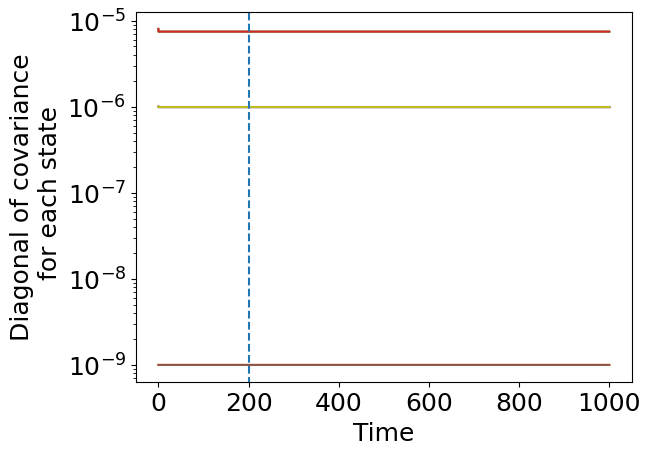

In [68]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(X.shape[0]):
    ax.plot(t, P[i,i,:])
    ax.set_yscale('log')
    
ax.set_xlabel('Time')
ax.set_ylabel('Diagonal of covariance\n for each state')
    
ax.vlines(200, 1e-10, 1e0, linestyles=['--'])

In [26]:
ix_converged = np.argmin( np.abs(t - 200) )
print(ix_converged)

2000


# Analyze error for all states once filter converged

Look at the correlation of the error covariance matrix vs the std dev of the error and mean abs error for each state. 

In [27]:
mean_err = []
for i in range(X.shape[0]):
    # recall X are the true states
    # recall xhat_fp are the estimated states
    
    mean_err.append( np.mean(np.abs(X[i,ix_converged:] - xhat_fp[i,ix_converged:])**2 ) )

In [28]:
std_err = []
for i in range(X.shape[0]):
    # recall X are the true states
    # recall xhat_fp are the estimated states
    
    std_err.append( np.std(X[i,ix_converged:] - xhat_fp[i,ix_converged:]) )

In [29]:
# steady state error covariance (it is pretty constant after this time)
P_ss = P_fp[ix_converged]

Text(0, 0.5, 'steady state error covariance')

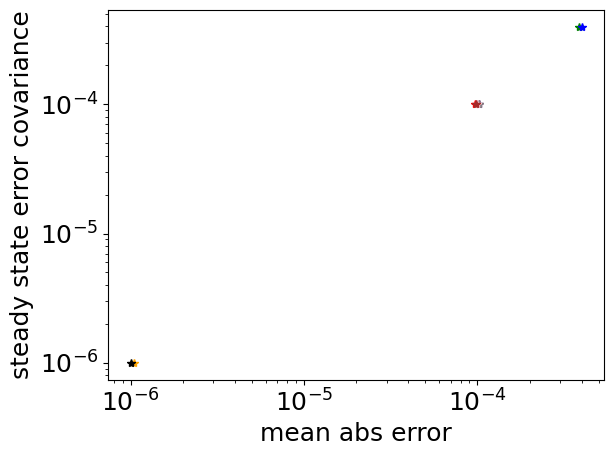

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)

colors=['red', 'orange', 'green', 'blue', 'purple', 'black', 'grey', 'pink', 'brown', 'cyan']

for i in range(len(mean_err)):
    ax.plot( np.array(mean_err)[i], np.diag(P_ss)[i], '*', color=colors[i])
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('mean abs error')
ax.set_ylabel('steady state error covariance')

Text(0, 0.5, 'steady state error covariance')

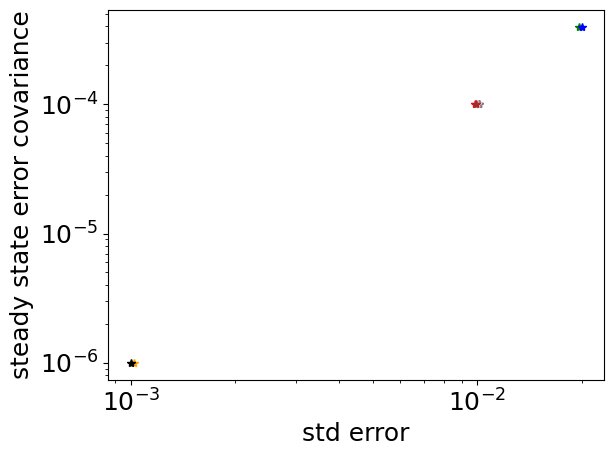

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)

colors=['red', 'orange', 'green', 'blue', 'purple', 'black', 'grey', 'pink', 'brown', 'cyan']

for i in range(len(std_err)):
    ax.plot( np.array(std_err)[i], np.diag(P_ss)[i], '*', color=colors[i])
ax.set_yscale('log')
ax.set_xscale('log')


ax.set_xlabel('std error')
ax.set_ylabel('steady state error covariance')

# Observability matrix

In [32]:
O = C
n = C.shape[0]
for i in range(0, ix_converged):
    O = np.vstack((O,  O[-n:,:]@A))

# Observability Gramian

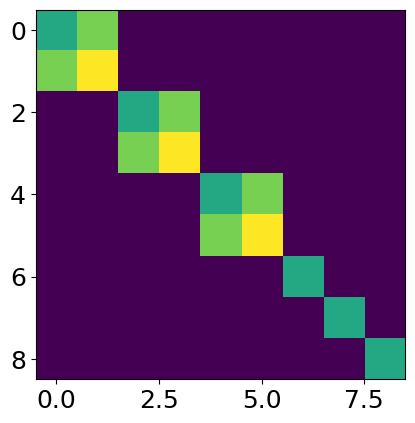

In [33]:
Wo = O.T@O

# hack Wo to plot it nicely
plt.imshow( np.log( np.abs(Wo) + 1e-3) )

# Eigenvalues of Wo

In [34]:
eigvals, eigvecs = np.linalg.eig(Wo)

In [35]:
# Sort eigenvalues from largest to smallest
ixsort = np.argsort(eigvals)[::-1]

In [36]:
eigvals[ixsort]

array([2.66901713e+07, 2.66901713e+07, 2.66901713e+07, 2.00100000e+03,
       2.00100000e+03, 2.00100000e+03, 5.00709438e+02, 5.00709438e+02,
       5.00709438e+02])

In [37]:
np.round( eigvecs[:, ixsort], 2)

array([[ 0.  , -0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.  ],
       [ 0.  , -1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.01],
       [-0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.  ,  0.  ],
       [-1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.01,  0.  ],
       [ 0.  ,  0.  , -0.01,  0.  ,  0.  ,  0.  , -1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -1.  ,  0.  ,  0.  ,  0.  ,  0.01,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

# Fisher Information

Here we will analyze the observability gramian as though it were the Fisher Information matrix. Recall from lecture that the FIM is equal to the observability gramian if Q=0 and R=Identity. 

In [57]:
inv_kFIM = np.linalg.inv(Wo)

IndexError: list index out of range

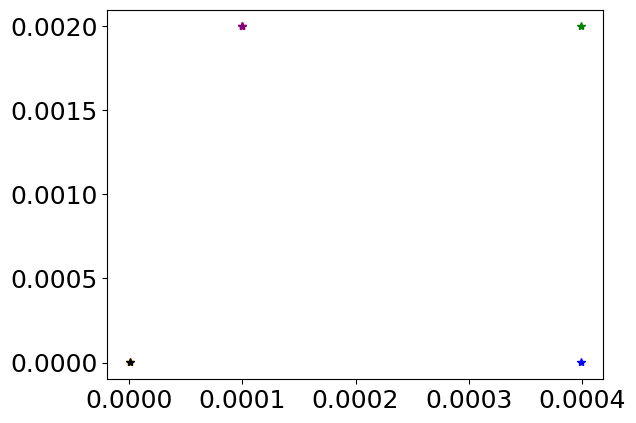

In [58]:
fig = plt.figure()
ax = fig.add_subplot(111)

colors=['red', 'orange', 'green', 'blue', 'purple', 'black']

for i in range(len(std_err)):
    ax.plot( np.diag( P_ss )[i], np.diag(inv_kFIM)[i], '*', color=colors[i])
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('error covariance')
ax.set_ylabel('inv (kFIM) -- a thing correlated\n with the Fisher Information^-1')

xline = np.logspace(-9, -2, 5)
ax.plot(xline, xline, '--')

# Exercise 1

Update the FIM calculation to include R

In [59]:
Rmini = np.diag( np.array(v)**2 )

In [60]:
Rmini

array([[1.e-04, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00],
       [0.e+00, 1.e-06, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00],
       [0.e+00, 0.e+00, 4.e-04, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 4.e-04, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-04, 0.e+00, 0.e+00, 0.e+00,
        0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-06, 0.e+00, 0.e+00,
        0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-04, 0.e+00,
        0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-04,
        0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        1.e-04]])

In [61]:
R = np.zeros([O.shape[0], O.shape[0]])

In [62]:
num_measurements = int( O.shape[0]/len(v) )
for i in range(num_measurements):
    ix = i*len(v)
    R[ix:ix+len(v),ix:ix+len(v)] = Rmini

In [63]:
FIM = O.T@np.linalg.inv(R)@O
inv_kFIM = np.linalg.inv(FIM)

7.496994019239587e-08
1.2389458578261773e-09
0.0019561149113568885
0.00018366844646884093
8.702897765490081e-05
1.3151891975568888e-08


(1e-16, 100.0)

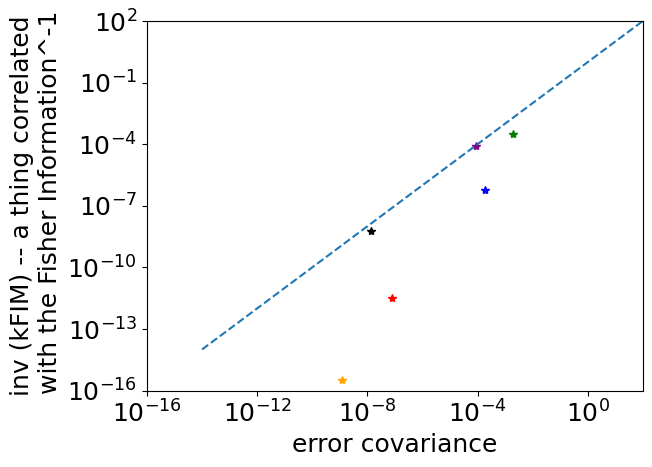

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

colors=['red', 'orange', 'green', 'blue', 'purple', 'black']

for i in range(len(std_err)):
    print(np.diag( P_ss )[i])
    ax.plot( np.diag( P_ss )[i], np.diag(inv_kFIM)[i], '*', color=colors[i])
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('error covariance')
ax.set_ylabel('inv (kFIM) -- a thing correlated\n with the Fisher Information^-1')

xline = np.logspace(-14, 2, 5)
ax.plot(xline, xline, '--')
ax.set_xlim(1e-16, 1e2)
ax.set_ylim(1e-16, 1e2)

# Exercise 2

By how much would adding the acceleration measurements (with noise stdev=0.000005) reduce the expected error covariance?

Reference this notebook: Week_3/C_Example_Planar_Quadrotor_KF_WORKEDOUT-addedaccel.ipynb

# observable